In [1]:
# Load necessary packages
using Alpine, PyPlot, Seaborn

In [2]:
# Read frames from LAMMPS trajectory file
frames = read_atoms("dump.tip4p.lammpstrj")

# If the coordinates are scaled to be in the range [0, 1] unscale them based on the box size
unscale!.(frames);

In [3]:
# To speed up the RDF calculation, split the simulation box into cells.
# num_cells specifies the number of cells per each dimension of the box
# (so num_cells = 10 would imply 10³ = 1,000 total cells)

num_cells = 24
r_cutoff = 15.0
Δr = 0.01

# Specify the number of frames at the end of the LAMMPS trajectory file
# to average over

num_frames = 40;

In [4]:
# Generate the x-axis values
x = rdf_axis(r_cutoff, Δr);

In [5]:
# This is the number of processor cores available on your system
println(ENV["JULIA_NUM_THREADS"], " processor cores available")

40 processor cores available


In [6]:
# Compute the component RDFs using all available processor cores
@time rdfs = rdf_components_all(frames[end-num_frames+1:end], r_cutoff, Δr, num_cells);

 28.517281 seconds (13.28 M allocations: 471.091 MiB)


In [7]:
# Obtain overall RDF by summing up component RDF functions
rdf_total = zeros(first(rdfs)[2])
for j in 1:5, i in 1:j
    rdf_total .+= rdfs["$i-$j"]
end;

## Plotting

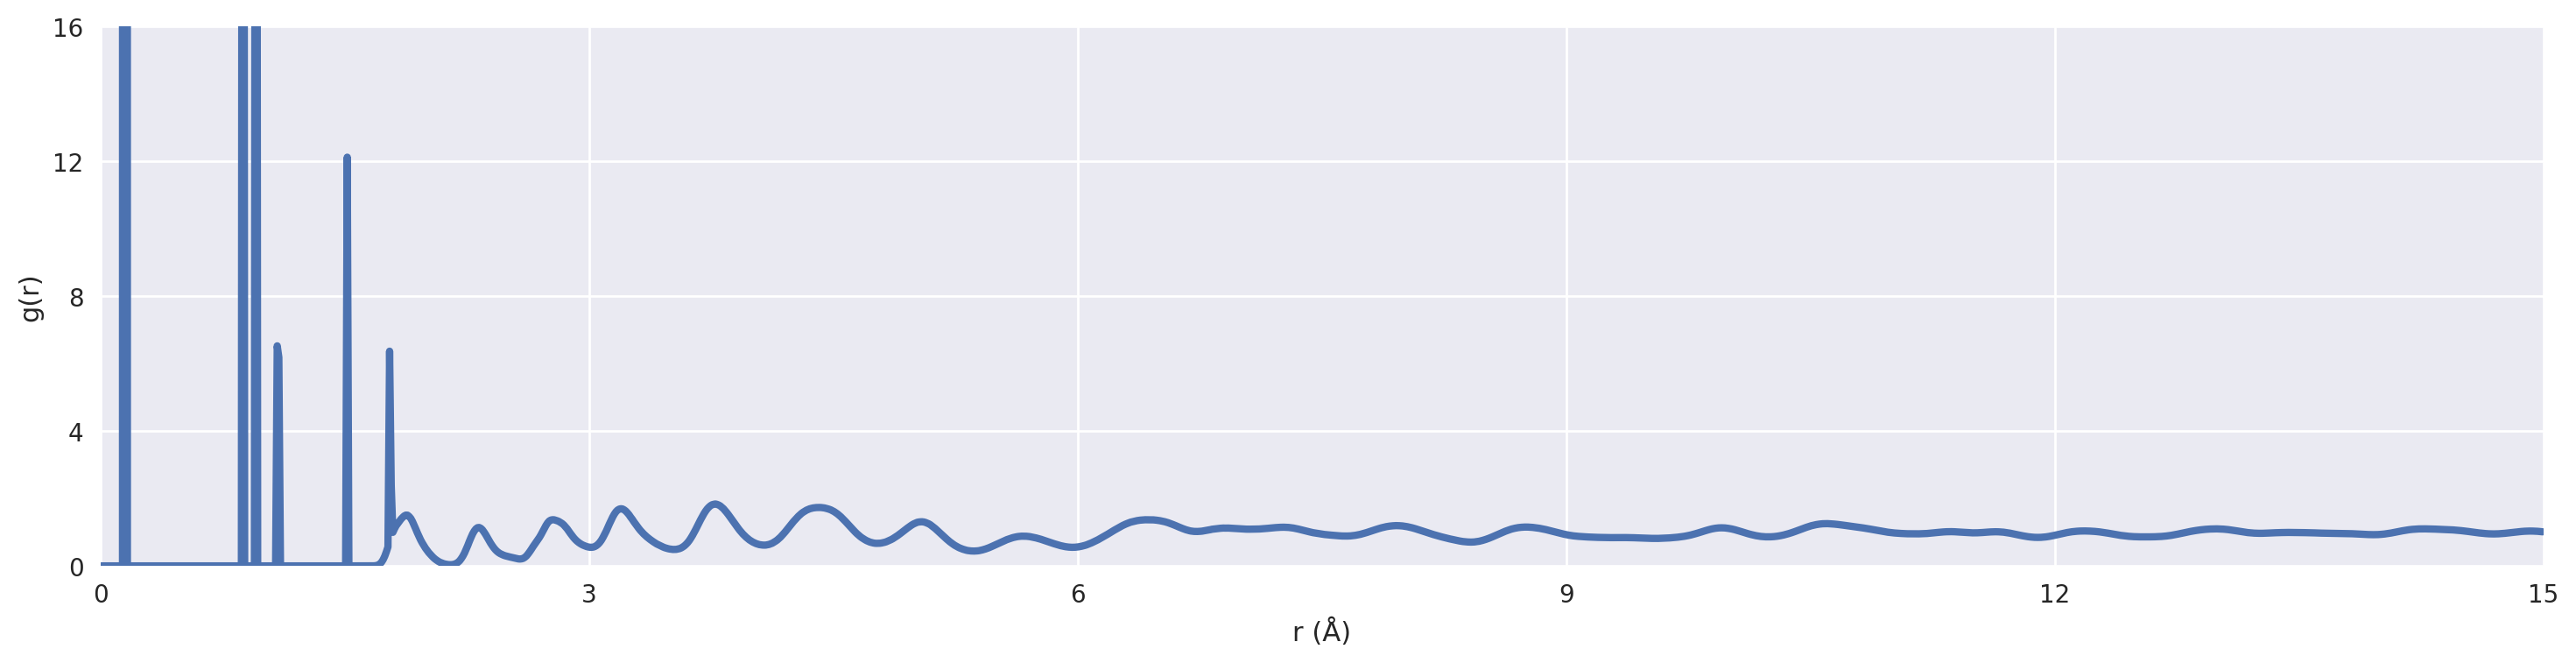

In [8]:
# Set the plot width and height
width = 18
height = 4

# Set the x axis range and the y axes ranges
xrange = 0:3:r_cutoff
yrange = 0:4:16

xtic = xrange
ytic = yrange

# Set the plot resolution and color palette
matplotlib[:rc]("savefig", dpi = 200)
figure(figsize = (width, height))

# Plot the overall RDF
plot(x, rdf_total, lw = 3.0)
xlabel("r (Å)")
ylabel("g(r)")
xticks(xtic)
yticks(ytic)
axis([minimum(xtic), maximum(xtic), minimum(ytic), maximum(ytic)]);

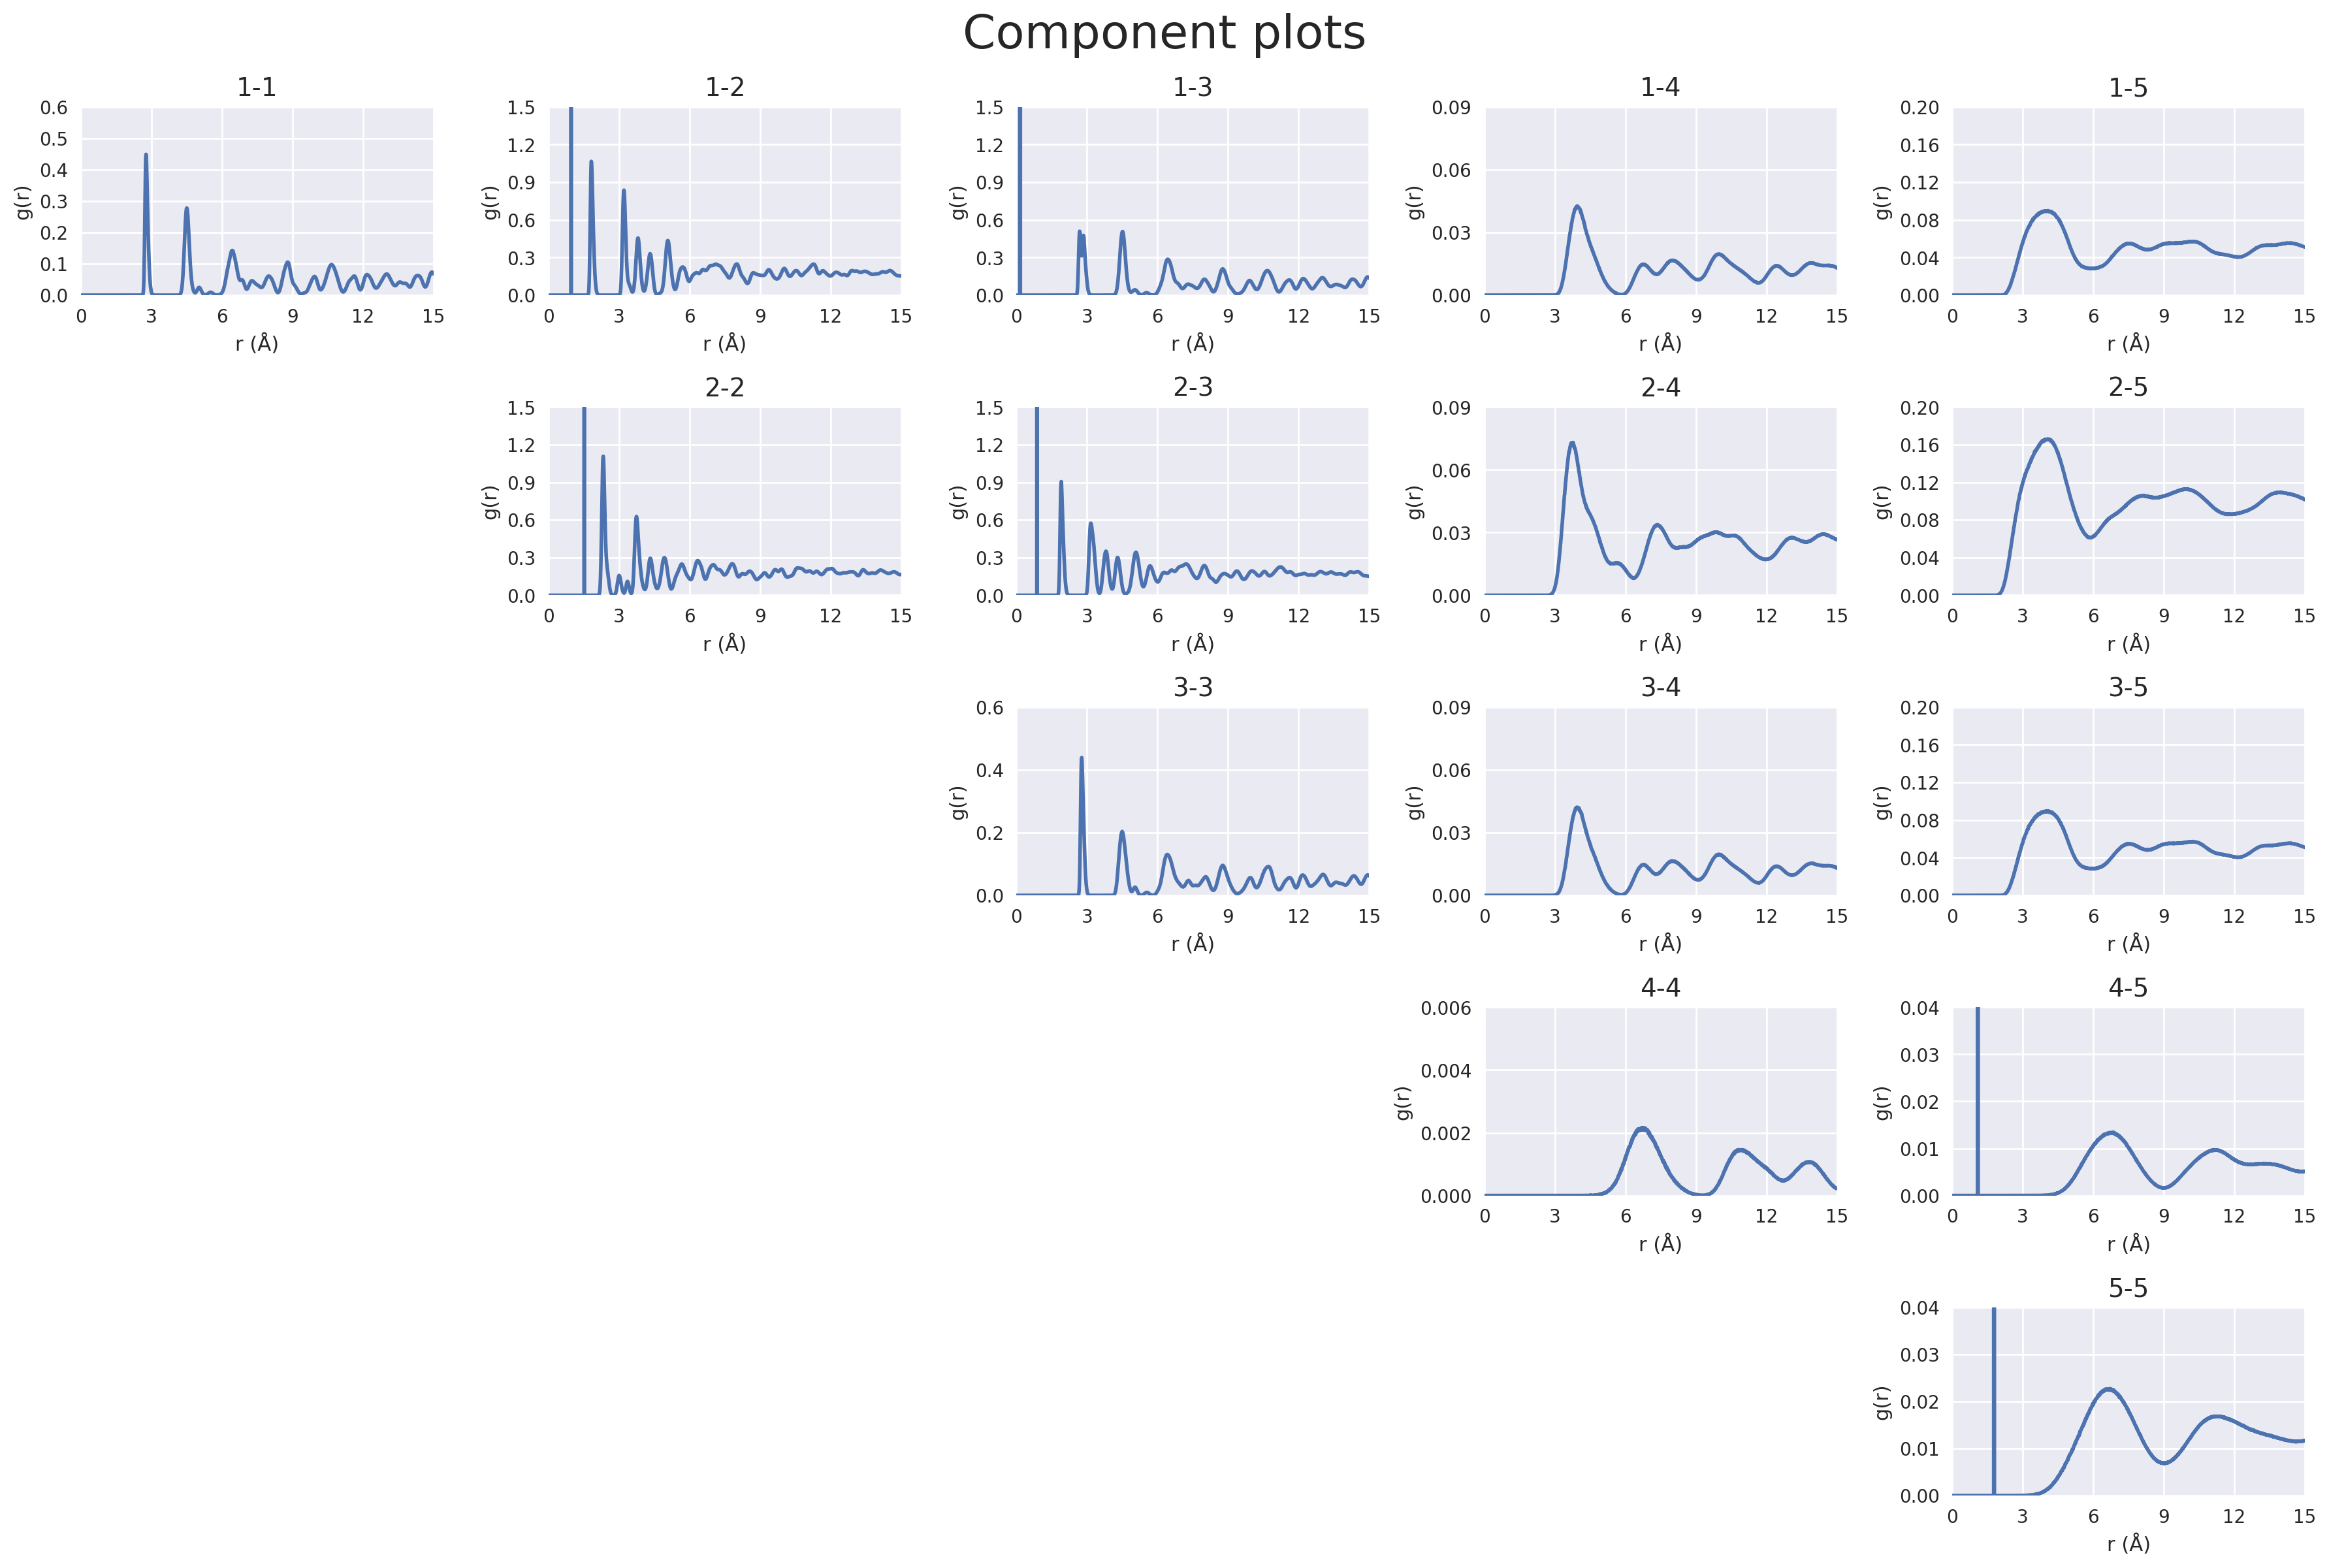

In [9]:
# Specify the number of individual components (atom types in this case)
num_components = 5

# Set the plot width and height
width = 18
height = 12

# Set the x axis range and the y axes ranges
xrange = 0 : 3 : r_cutoff
yranges = Dict(
    "1-1" => 0 :  0.1   : 0.6,
    "1-2" => 0 :  0.3   : 1.5,
    "1-3" => 0 :  0.3   : 1.5,
    "1-4" => 0 :  0.03  : 0.09,
    "1-5" => 0 :  0.04  : 0.2,
    "2-2" => 0 :  0.3   : 1.5,
    "2-3" => 0 :  0.3   : 1.5,
    "2-4" => 0 :  0.03  : 0.09,
    "2-5" => 0 :  0.04  : 0.2,
    "3-3" => 0 :  0.2   : 0.6,
    "3-4" => 0 :  0.03  : 0.09,
    "3-5" => 0 :  0.04  : 0.2,
    "4-4" => 0 :  0.002 : 0.006,
    "4-5" => 0 :  0.01  : 0.04,
    "5-5" => 0 :  0.01  : 0.04
)

# Set the plot resolution and color palette
matplotlib[:rc]("savefig", dpi = 200)
figure(figsize = (width, height))

# Plot each component RDF as a subplot
for i in 1:num_components, j in 1:num_components
    
    # Only plot upper triangular pairs of component RDFs
    i > j && continue
    
    # Specify the component RDF
    label = "$i-$j"
    
    xtic = xrange
    ytic = yranges[label]
    
    subplot_index = num_components*(i-1) + j
    subplot(num_components, num_components, subplot_index)
    plot(x, rdfs[label], lw = 2.0)
    
    title(label, fontsize = 14)
    xlabel("r (Å)")
    ylabel("g(r)")
    xticks(xtic)
    yticks(ytic)
    axis([minimum(xtic), maximum(xtic), minimum(ytic), maximum(ytic)])
end

tight_layout()
overall_title = suptitle("Component plots", fontsize = 26)
overall_title[:set_y](1.0)
subplots_adjust(top = 0.94);